In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import wandb
from wandb.keras import WandbCallback

In [3]:
import pandas as pd
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [4]:
from projectwind.Energy_Forecast import WindowGenerator, get_LSTM_data
from projectwind.trainer import plot_loss

# Get Data

In [318]:
train_df, val_df, test_df = get_LSTM_data(25)

### Fetching 25xWTG data ###
### Fetching weather API data ###
### Preparing datasets ###


## Add adapted wind speeds

## Data analysis

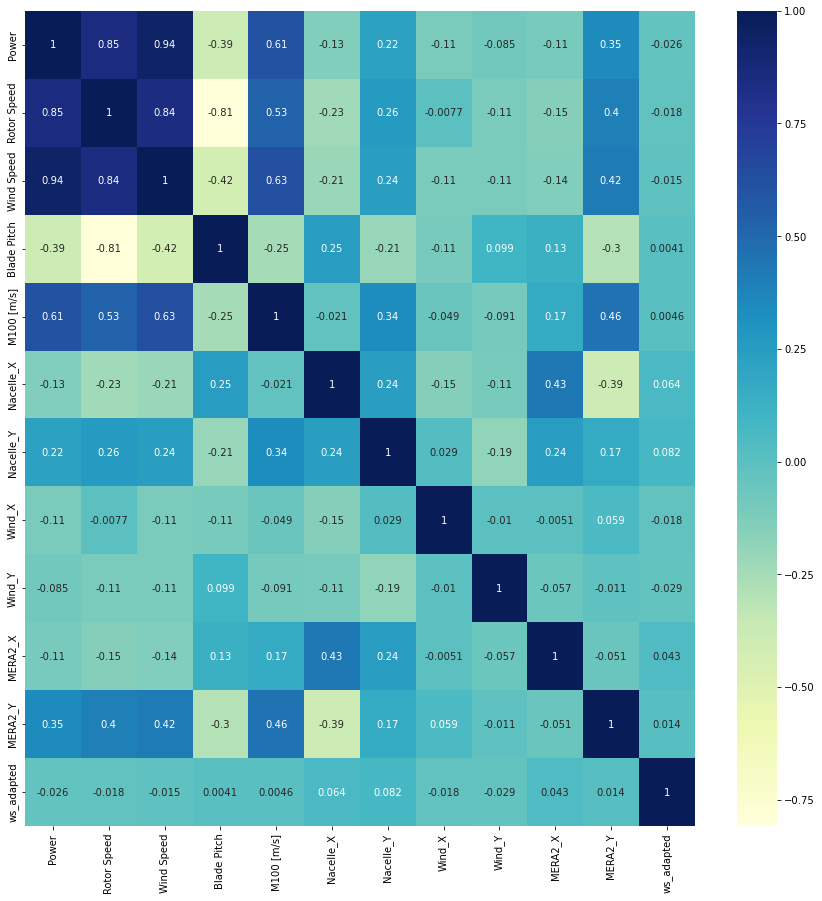

In [114]:
# 100m windspeeds - 2hr resampling
temp = train_df[0]

# plotting correlation heatmap
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(axes=ax, data=temp.corr(), cmap="YlGnBu", annot=True);

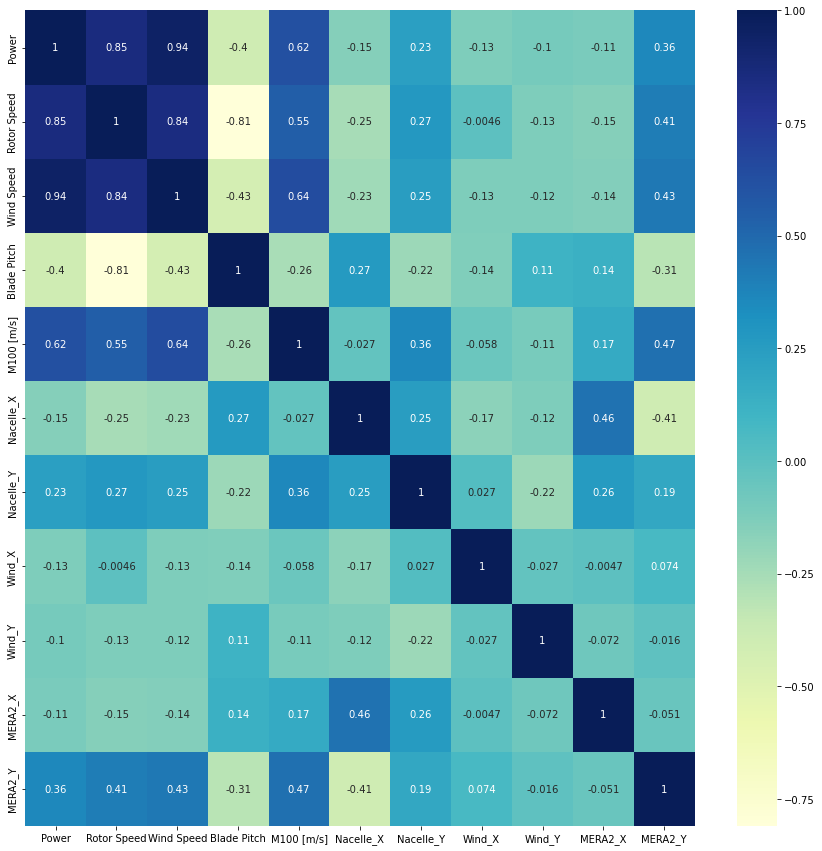

In [8]:
# 100m wind speeds
temp = train_df[0]

# plotting correlation heatmap
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(axes=ax, data=temp.corr(), cmap="YlGnBu", annot=True);

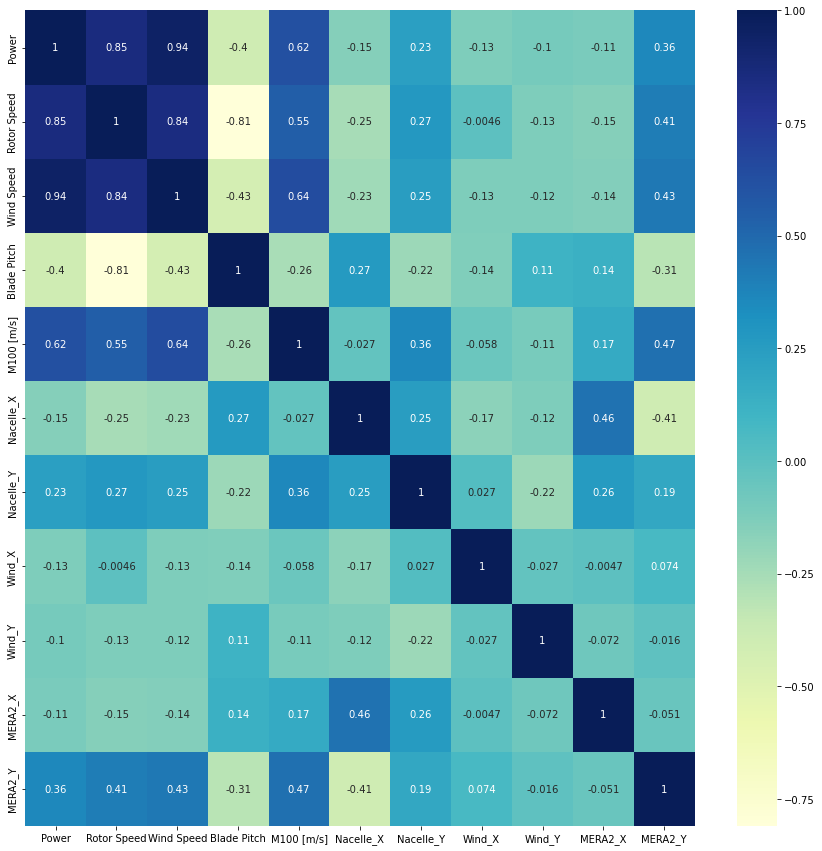

In [9]:
# 50m windspeeds
temp = train_df[0]

# plotting correlation heatmap
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(axes=ax, data=temp.corr(), cmap="YlGnBu", annot=True);

## Select window and prepare sequences

In [714]:
n_steps_in = 3*24    # hrs 
n_steps_out = 6    # hrs

window = WindowGenerator(input_width=n_steps_in, label_width=n_steps_out, shift=n_steps_out,
                         train_df=train_df, val_df=val_df, test_df=test_df,
                         input_columns=['Power','Rotor Speed', 'Wind Speed', 'Blade Pitch',
                                       'Nacelle_X', 'Nacelle_Y', 'Wind_X', 'Wind_Y'],
                         forecast_columns=['Wind Speed'],
                         label_columns=['Power'])

In [715]:
window

Total window size: 78
Input column name(s): ['Power', 'Rotor Speed', 'Wind Speed', 'Blade Pitch', 'Nacelle_X', 'Nacelle_Y', 'Wind_X', 'Wind_Y']
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Forecast column name(s): ['Wind Speed']
Forecast indices: [72 73 74 75 76 77]
Label column name(s): ['Power']
Label indices: [72 73 74 75 76 77]

In [716]:
X_train, X_fc_train, y_train =  window.train
X_val,  X_fc_val, y_val   =  window.val
X_test, X_fc_test, y_test  =  window.test

## Find quartiles & make bins

In [717]:
y_train = pd.DataFrame(y_train).iloc[:,0].apply(lambda x: 0 if x < 2600 else 1 if 2600 < x < 5500 else 2)
y_val = pd.DataFrame(y_val).iloc[:,0].apply(lambda x: 0 if x < 2600 else 1 if 2600 < x < 5500 else 2)
y_test = pd.DataFrame(y_test).iloc[:,0].apply(lambda x: 0 if x < 2600 else 1 if 2600 < x < 5500 else 2)

In [718]:
# Check class balance
print(
    y_train.value_counts()[0] + y_val.value_counts()[0] + y_test.value_counts()[0], 
    y_train.value_counts()[1] + y_val.value_counts()[1] + y_test.value_counts()[1],
    y_train.value_counts()[2] + y_val.value_counts()[2] + y_test.value_counts()[2])

2199 2186 2365


In [719]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [720]:
y_train = y_train.reshape(y_train.shape[0], 1)
y_val   = y_val.reshape(y_val.shape[0], 1)
y_test  = y_test.reshape(y_test.shape[0], 1)

In [721]:
X_train.shape, X_fc_train.shape, y_train.shape

((4725, 72, 8), (4725, 6, 1), (4725, 1))

In [722]:
X_val.shape, X_fc_val.shape, y_val.shape

((1350, 72, 8), (1350, 6, 1), (1350, 1))

In [723]:
X_test.shape, X_fc_test.shape, y_test.shape

((675, 72, 8), (675, 6, 1), (675, 1))

# Build Model

In [138]:
val_performance = pd.DataFrame()
test_performance = pd.DataFrame()

The models below combine two models (1) LSTM model for the performance of the wind turbine & (2) Dense model for the weather forecast. 

These two model outputs are concatenated & ran through two NN Dense layers to produce the output

In [459]:
def hybrid_model(): 
    
    # Historic model
    input_perf = tf.keras.layers.Input(shape=(n_steps_in, X_train.shape[2]))
    x = tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2)(input_perf)
    x = tf.keras.layers.LSTM(32, return_sequences=False, dropout=0.2)(x)
    x_perf = tf.keras.layers.Dense(16, activation='relu')(x)
    
    # Weather forecast model
    input_fc = tf.keras.layers.Input(shape=(n_steps_out, X_fc_train.shape[2]))
    x = tf.keras.layers.LSTM(32, return_sequences=True)(input_fc)
    x = tf.keras.layers.LSTM(32, return_sequences=False)(x)
    x_fc = tf.keras.layers.Dense(16, activation='relu')(x)
    
    # Combined model
    combined = tf.keras.layers.concatenate([x_perf, x_fc], axis=1)
    x = tf.keras.layers.Dense(32, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
    
    model = tf.keras.models.Model(inputs=[input_perf, input_fc], outputs=outputs)
    
    return model

In [727]:
def hybrid_model(): 
    
    # Historic model
    input_perf = tf.keras.layers.Input(shape=(n_steps_in, X_train.shape[2]))
    x = tf.keras.layers.LSTM(128, return_sequences=True)(input_perf)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=False)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x_perf = tf.keras.layers.Dense(64, activation='relu')(x)
    
    # Weather forecast model
    input_fc = tf.keras.layers.Input(shape=(n_steps_out, X_fc_train.shape[2]))
    x_fc = tf.keras.layers.LSTM(128, return_sequences=True)(input_fc)
    x_fc = tf.keras.layers.LSTM(128, return_sequences=True)(x_fc)
    x_fc = tf.keras.layers.LSTM(128, return_sequences=True)(x_fc)
    x_fc = tf.keras.layers.LSTM(128, return_sequences=False)(x_fc)
    x_fc = tf.keras.layers.Dense(128, activation='relu')(x_fc)
    x_fc = tf.keras.layers.Dense(128, activation='relu')(x_fc)
    x_fc = tf.keras.layers.Dense(64, activation='relu')(x_fc)
    x_fc = tf.keras.layers.Dense(64, activation='relu')(x_fc)
    x_fc = tf.keras.layers.Dense(64, activation='relu')(x_fc)
    
    # Combined model
    combined = tf.keras.layers.concatenate([x_perf, x_fc], axis=1)
    x = tf.keras.layers.Dense(128, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation="relu")(x)
    
    model = tf.keras.models.Model(inputs=[input_perf, input_fc], outputs=outputs)
    
    return model

# Run Model

In [728]:
hs_model=hybrid_model()
hs_model.summary()

Model: "model_97"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_200 (InputLayer)          [(None, 72, 8)]      0                                            
__________________________________________________________________________________________________
input_201 (InputLayer)          [(None, 6, 1)]       0                                            
__________________________________________________________________________________________________
lstm_655 (LSTM)                 (None, 72, 128)      70144       input_200[0][0]                  
__________________________________________________________________________________________________
lstm_659 (LSTM)                 (None, 6, 128)       66560       input_201[0][0]                  
___________________________________________________________________________________________

In [729]:
wandb.init(project="energy_models", entity="shmiggit")

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
lr,███████████████▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▆▆▅▄▄▄▃▃▃▂▂▃▂▂▁▁▁▁▁▁▁▁
val_loss,▃▄▄▂▁▂▃▃▃▄▄▄▆▇▇▆▇▇█▇▇██▇█
val_mean_absolute_error,▆██▄▂▁▂▁▃▅▄▆▅▇▅▅▄▄▅▅▅▅▅▅▅
best_epoch,4
best_val_loss,0.32324
epoch,24
loss,0.12713
lr,5e-05


In [730]:
model_name = 'Energy_model_floral-snowflake-66'

In [731]:
wandb.config = {
    "model_type" : 'LSTM',
    "learning_rate": 0.001,
    "epochs": 100,
    "batch_size": 32
}

In [732]:
## Single class output / MSE 
def compile_and_fit(model, window):
    
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=20,
                                                      mode='min',
                                                      restore_best_weights=True)

    # Reduce learning rate by an order of magnitude if val_loss does not improve for 20 epoch
    rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.1,
                                                 min_lr=1e-7,
                                                 verbose=1,
                                                 patience=10)
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(learning_rate=0.0005),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    checkpoint=tf.keras.callbacks.ModelCheckpoint(f"./checkpoint/checkpoint_{model_name}.h5", save_best_only=True, save_weights_only=True)
    
    history = model.fit([X_train, X_fc_train], y_train, 
                        epochs=200,
                        validation_data=([X_val, X_fc_val], y_val),
                        #batch_size=32,
                        callbacks=[early_stopping, rlrop, checkpoint, WandbCallback()])
    model.save(f'./checkpoint/{model_name}.h5')
    return history

In [733]:
model = hybrid_model()
history = compile_and_fit(model, window)

Epoch 1/200
148/148 [==============================] - 13s 40ms/step - loss: 0.6120 - mean_absolute_error: 0.6190 - val_loss: 0.2614 - val_mean_absolute_error: 0.4011
Epoch 2/200
148/148 [==============================] - 4s 28ms/step - loss: 0.3181 - mean_absolute_error: 0.4055 - val_loss: 0.2500 - val_mean_absolute_error: 0.3988
Epoch 3/200
148/148 [==============================] - 4s 27ms/step - loss: 0.2551 - mean_absolute_error: 0.3541 - val_loss: 0.1366 - val_mean_absolute_error: 0.2685
Epoch 4/200
148/148 [==============================] - 4s 27ms/step - loss: 0.2186 - mean_absolute_error: 0.3213 - val_loss: 0.1783 - val_mean_absolute_error: 0.3379
Epoch 5/200
148/148 [==============================] - 4s 27ms/step - loss: 0.2095 - mean_absolute_error: 0.3172 - val_loss: 0.1322 - val_mean_absolute_error: 0.2632
Epoch 6/200
148/148 [==============================] - 4s 27ms/step - loss: 0.2038 - mean_absolute_error: 0.3112 - val_loss: 0.1016 - val_mean_absolute_error: 0.2185
Epo

In [734]:
val_performance[model_name] = model.evaluate([X_val, X_fc_val], y_val)
test_performance[model_name] = model.evaluate([X_test, X_fc_test], y_test)

22/22 [==============================] - 0s 10ms/step - loss: 0.1027 - mean_absolute_error: 0.1641


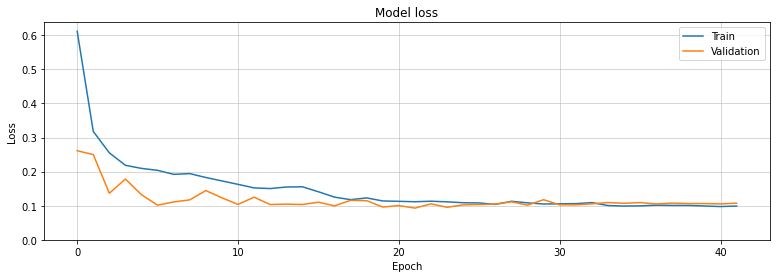

In [735]:
plot_loss(history)

In [737]:
y_pred = model.predict([X_val, X_fc_val], batch_size=1)

### Proba given

### Class given

In [738]:
y_pred = y_pred.round()

In [739]:
np.unique(y_pred)

array([0., 1., 2.], dtype=float32)

In [740]:
results_df = pd.DataFrame({"actual": y_val.reshape(-1),
                           "predicted": y_pred.reshape(-1)})#Store results in dataframe

confusion_matrix = pd.crosstab(index= results_df['actual'],
                               columns = results_df['predicted'])

confusion_matrix

predicted,0.0,1.0,2.0
actual,,,
0,316,22,2
1,43,381,8
2,0,82,496


### Plot function

# Load Latest Model

In [704]:
model = tf.keras.models.load_model('./checkpoint/Energy_model_divine-firebrand-59.h5')

In [705]:
y_pred = model.predict([X_val, X_fc_val], batch_size=1)